In [1]:

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np

BATCH_SIZE = 30
EPOCHS = 120
SEED = 2


NameError: ignored

In [3]:
!pip install pytket-qiskit
!pip install lambeq==0.3.3 # MAKE SURE YOU INSTALL THIS VERSION TO MAKE SURE WE ALL ON THE SAME PAGE :)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [4]:

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

In [5]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1


In [6]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)


Evaluating checksum: 0.0%|          |0.000/1.533GB [00:00<?]

Extracting model...


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


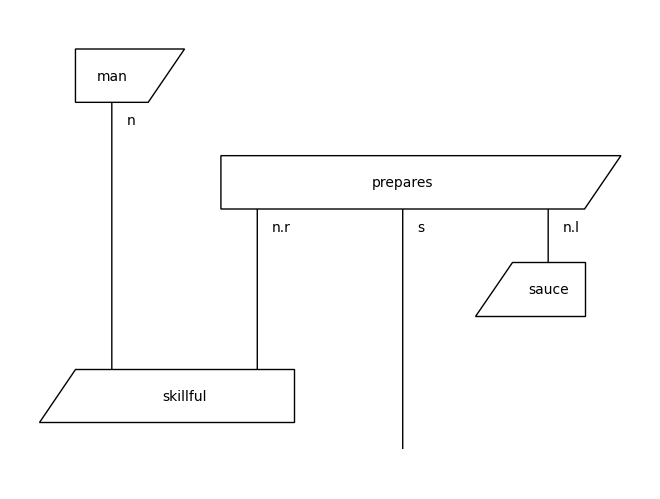

In [7]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

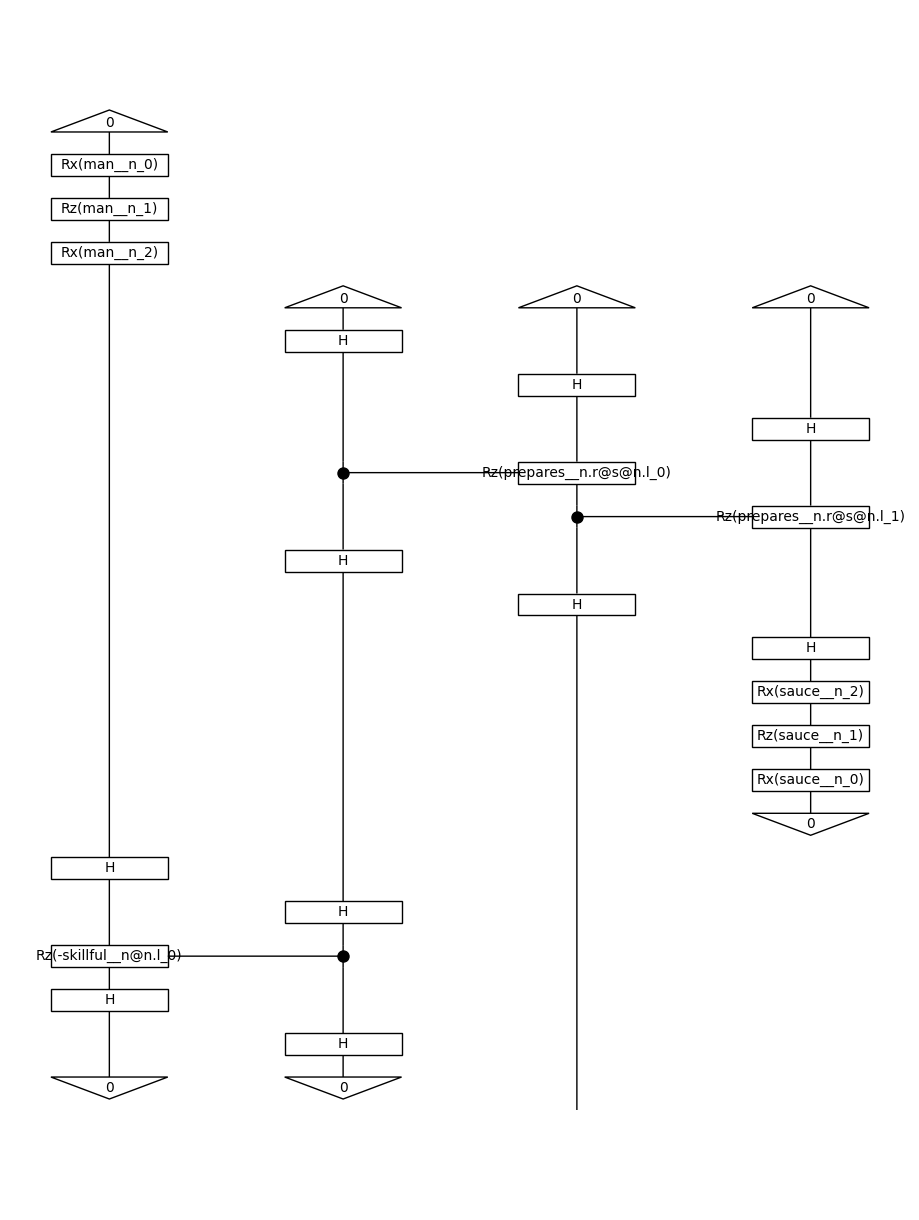

In [8]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

In [9]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
# model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

# Are you connected to some GPU-enabled runtime? In that case, use JIT models instead!!


from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits + test_circuits

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)


In [10]:

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss(use_jax = True )

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [11]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)


In [12]:

from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [13]:
trainer.fit(train_dataset, val_dataset, log_interval=4)


Epoch 4:    train/loss: 0.3047   valid/loss: 0.6505   train/acc: 0.6000   valid/acc: 0.6667
Epoch 8:    train/loss: 0.6210   valid/loss: 0.5765   train/acc: 0.6714   valid/acc: 0.7000
Epoch 12:   train/loss: 0.6626   valid/loss: 0.5868   train/acc: 0.7857   valid/acc: 0.6333
Epoch 16:   train/loss: 0.3070   valid/loss: 0.4754   train/acc: 0.7857   valid/acc: 0.7000
Epoch 20:   train/loss: 0.3487   valid/loss: 0.4503   train/acc: 0.8000   valid/acc: 0.7667
Epoch 24:   train/loss: 0.3583   valid/loss: 0.3980   train/acc: 0.8571   valid/acc: 0.8000
Epoch 28:   train/loss: 0.3505   valid/loss: 0.3901   train/acc: 0.8286   valid/acc: 0.8000
Epoch 32:   train/loss: 0.3533   valid/loss: 0.3883   train/acc: 0.8286   valid/acc: 0.8000
Epoch 36:   train/loss: 0.1736   valid/loss: 0.3787   train/acc: 0.8714   valid/acc: 0.7667
Epoch 40:   train/loss: 0.2387   valid/loss: 0.3761   train/acc: 0.8857   valid/acc: 0.7667
Epoch 44:   train/loss: 0.3978   valid/loss: 0.3610   train/acc: 0.8000   valid/

TypeError: ignored

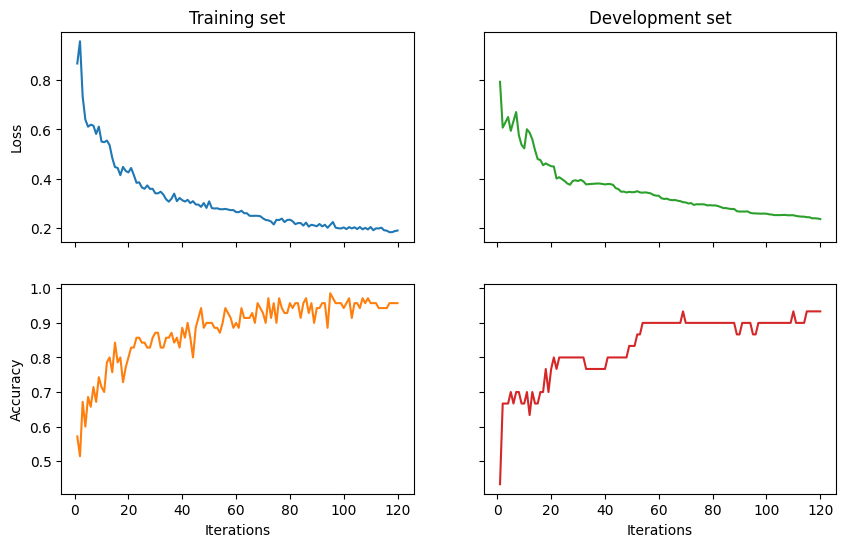

In [14]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs +1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)

In [15]:
test_acc = acc(model(test_circuits), np.array(test_labels))

In [16]:
print(test_acc)

0.8333334


In [22]:
model(test_circuits[:5])



Array([[0.32481962, 0.6751804 ],
       [0.98837584, 0.01162417],
       [0.00886379, 0.99113625],
       [0.9763755 , 0.02362449],
       [0.5411081 , 0.45889193]], dtype=float32)

In [23]:
print(test_labels)

[[1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]]


In [31]:
model([test_circuits[2]])

Array([[0.00886379, 0.99113625]], dtype=float32)

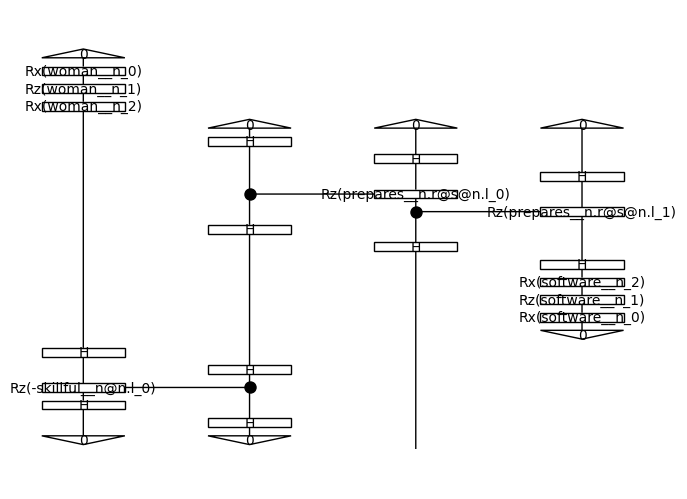

In [32]:
test_circuits[2].draw()